In [4]:
import sympy as sp
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import warnings
from numba.core.errors import NumbaWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=NumbaWarning)
from scipy.optimize import minimize, least_squares

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_covinv_chol, points_at_iteration, X_mu, X_Sigma, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs
from aeons.lm_partial import analytic_lm_params
from aeons.bayes import logPr_bayes, logPr_laplace, logPr_gaussian, minimise_ls, minimise_bayes, minimise_gaussian
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
from aeons.hessian import hess

Cache analytic expressions to save time

### **Errorbars in parameters**

Laplace approximation for likelihood function around the maximum:

$$ \log P(\bm{\theta} \mid \{\log L_i \}) \approx
\log P'(\bm{\theta}) = \log P'(\bm{\theta}_0) - \frac{1}{2} (\bm{\theta} - \bm{\theta}_0)^\intercal \bm{A} (\bm{\theta} - \bm{\theta}_0)$$
where
$$ A_{ij} = \left . - \frac{\partial^2}{\partial\theta_i \partial\theta_j} \log P(\bm{\theta} \mid \{\log L_i \}) \right\vert_{\bm{\theta} = \bm{\theta}_0} = -H_{ij}$$

#### **Evidence for model**

$$ \log Z = \log L_\mathrm{max} + \frac{1}{2} \log |2\pi\Sigma| - \log V_\pi $$
$$ \log Z = \log P'(\bm{\theta}_0)  + \frac{1}{2} \log |2\pi H^{-1}| - \log V_\pi $$
$$ Z = P'(\bm{\theta}_0) \sqrt{\frac{2\pi |H^{-1}|}{V_\pi}} $$


Find Hessian numerically using `autograd`, compare to analytical expression for simple cases

If 1D $\theta$, then 1D Gaussian, $A$ is a constant. Check with meshgrid in 2D.

In [3]:
import numpy as np
import sympy as sp
import numba as nb

logLmax, d, sigma = sp.symbols('\log{L_\mathrm{max}} d \sigma')
X_i, logL_i, logL_j = sp.symbols('X_i \log{L_i} \log{L_j}')
mu_i, mu_j = sp.symbols('\mu_i, \mu_j')


def f(X_i, logLmax, d, sigma):
    return logLmax - X_i**(2/d)/(2*sigma**2)

def fprime(X_i, logLmax, d, sigma):
    return sp.diff(f(X_i, logLmax, d, sigma), X_i)

def abs_fprime(X_i, logLmax, d, sigma):
    return - fprime(X_i, logLmax, d, sigma)

def X_logLi(logL_i, logLmax, d, sigma):
    return (2*sigma**2 * (logLmax - logL_i))**(d/2)

def log_abs_fprime_Xstar(logL_i, logLmax, d, sigma):
    Xstar_i = X_logLi(logL_i, logLmax, d, sigma)
    return sp.log(abs_fprime(X_i, logLmax, d, sigma).subs(X_i, Xstar_i))

def cross_terms(logL_i, logL_j, logLmax, d, sigma):
    Xstar_i = X_logLi(logL_i, logLmax, d, sigma)
    Xstar_j = X_logLi(logL_j, logLmax, d, sigma)
    return (Xstar_i - mu_i) * (Xstar_j - mu_j)

def hess_fprime_i(theta_1, theta_2):
    symbolic_expr = sp.diff(log_abs_fprime_Xstar(logL_i, logLmax, d, sigma), theta_1, theta_2)
    symbolic_expr = sp.simplify(symbolic_expr)
    numeric_func = sp.lambdify([logL_i, logLmax, d, sigma], symbolic_expr)
    return numeric_func

def hess_cross_ij(theta_1, theta_2):
    symbolic_expr = sp.simplify(sp.diff(cross_terms(logL_i, logL_j, logLmax, d, sigma), theta_1, theta_2))
    numeric_func = sp.lambdify([logL_i, logL_j, mu_i, mu_j, logLmax, d, sigma], symbolic_expr)
    return numeric_func

def hess_logfprime(logL, theta_max, theta_1, theta_2):
    if set([theta_1, theta_2]) == set([logLmax, sigma]):
        return 0
    return hess_fprime_i(theta_1, theta_2)(logL, *theta_max).sum()

def hess_cross(logL, mean, covinv, theta_max, theta_1, theta_2):
    hess_tt_ij = hess_cross_ij(theta_1, theta_2)
    k = len(logL)
    @nb.jit
    def quad():
        quad = 0
        for i in range(k):
            cross_i = hess_tt_ij(logL[i], logL, mean[i], mean, *theta_max) * covinv[i]
            quad += cross_i.sum()
        return quad
    return quad()

def hess_tt(logL, mean, covinv, theta_max, theta_1, theta_2):
    return - hess_logfprime(logL, theta_max, theta_1, theta_2) - 1/2 * hess_cross(logL, mean, covinv, theta_max, theta_1, theta_2)


def hess(logL, mean, covinv, theta_max):
    dim = 3
    hess = np.zeros((dim, dim))
    hess[0][0] = hess_tt(logL, mean, covinv, theta_max, logLmax, logLmax)
    hess[0][1] = hess[1][0] = hess_tt(logL, mean, covinv, theta_max, logLmax, d)
    hess[0][2] = hess[2][0] = hess_tt(logL, mean, covinv, theta_max, logLmax, sigma)
    hess[1][1] = hess_tt(logL, mean, covinv, theta_max, d, d)
    hess[1][2] = hess[2][1] = hess_tt(logL, mean, covinv, theta_max, d, sigma)
    hess[2][2] = hess_tt(logL, mean, covinv, theta_max, sigma, sigma)
    return hess

### **Verifying Hessian obtained is a good approximation near the maximum**

In [6]:
nk = 500 * np.ones(500)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
X = generate_Xs(nk)
theta_true = np.array([1, 10, 0.1])
y = full.func(X, theta_true)
theta_max = minimise_bayes(y, full, mean_X, covinv_X, theta_true).x
logLmax0, d0, sigma0 = theta_max
print(f'{theta_max}')
print(f'pr(theta_true): {logPr_bayes(y, full, mean_X, covinv_X, theta_true)}')
print(f'pr(theta_b): {logPr_bayes(y, full, mean_X, covinv_X, theta_max)}')

[14.83929467 12.9983419   0.08852233]
pr(theta_true): -1617.742222859667
pr(theta_b): -1615.7933252848436


In [9]:
def minimise_bayes(logL, likelihood, mean, covinv, x0):
    def func(theta):
        return - logPr_bayes(logL, likelihood, mean, covinv, theta)
    solution = minimize(func, x0)
    return solution

In [10]:
Hinv_scipy = minimise_bayes(y, full, mean_X, covinv_X, theta_true).hess_inv
H_scipy = np.linalg.inv(Hinv_scipy)

In [11]:
H_scipy

array([[ 1.42738166e+03, -2.29284931e+00,  2.76826371e+06],
       [-2.29284930e+00,  9.23157205e+00, -5.53381338e+02],
       [ 2.76826371e+06, -5.53381339e+02,  5.37053966e+09]])

In [488]:
covinv_scipy = np.linalg.inv(-H_scipy)

In [486]:
np.linalg.eigvals(H_scipy)

array([7.27984103e+07, 4.97969088e+03, 1.33972574e-01])

In [7]:
H = hess(y, mean_X, covinv_X, theta_max)
H

array([[-2.61382216e+03,  1.52411485e+00, -3.76771613e+06],
       [ 1.52411485e+00, -4.95923244e+00, -4.99495301e+03],
       [-3.76771613e+06, -4.99495301e+03, -5.43075093e+09]])

In [8]:
np.linalg.eigvals(H)

array([-5.43075354e+09,  3.18240432e+00, -8.01409799e+00])

In [409]:
A = -H
cov_theta = np.linalg.inv(A)

In [477]:
cov_theta

array([[-6.84579977e-06, -3.01626787e-04,  6.24041480e-06],
       [-3.01626787e-04, -2.95784537e-03,  2.75775374e-04],
       [ 6.24041480e-06,  2.75775374e-04, -5.65553297e-06]])

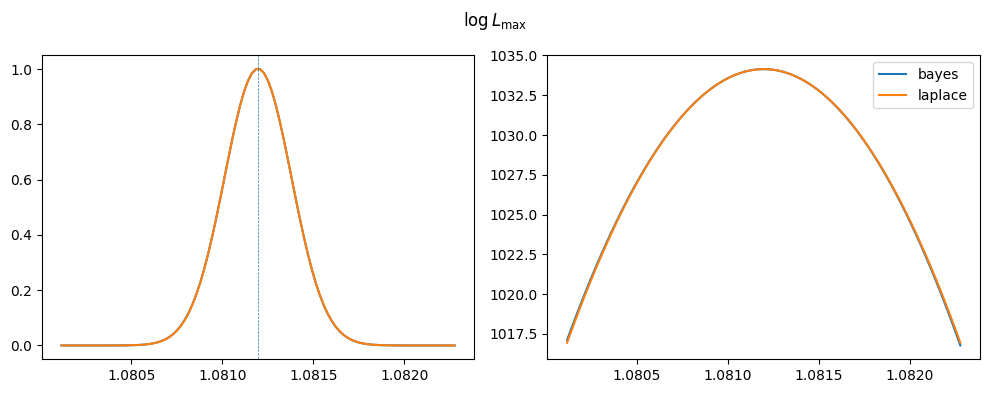

In [422]:
logLmaxs = np.linspace(logLmax0*0.999, logLmax0*1.001, 100)
prs_bayes = np.zeros_like(logLmaxs)
prs_laplace = np.zeros_like(logLmaxs)
logprmax = logPr_bayes(y, full, mean_X, covinv_X, theta_max)

for i, logLmax_ in enumerate(logLmaxs):
    prs_bayes[i] = logPr_bayes(y, full, mean_X, covinv_X, [logLmax_, d0, sigma0])
    prs_laplace[i] = logPr_laplace(np.array([logLmax_]), logprmax, logLmax0, H[0][0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(logLmaxs, np.exp(prs_bayes - prs_bayes.max()), label='bayes')
ax1.plot(logLmaxs, np.exp(prs_laplace - prs_laplace.max()), label='laplace')
ax1.axvline(x=logLmax0, ls='--', lw=.5)
ax2.plot(logLmaxs, prs_bayes, label='bayes')
ax2.plot(logLmaxs, prs_laplace, label='laplace')
plt.suptitle('$\log{L_\mathrm{max}}$', y=0.97)
plt.legend();
plt.tight_layout()

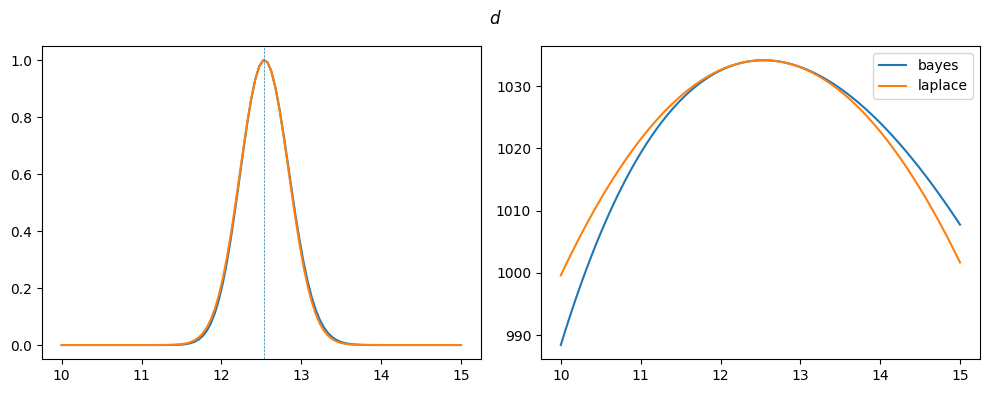

In [432]:
ds = np.linspace(10, 15, 100)
prs_bayes = np.zeros_like(ds)
prs_laplace = np.zeros_like(ds)
logprmax = logPr_bayes(y, full, mean_X, covinv_X, theta_max)

for i, d_ in enumerate(ds):
    prs_bayes[i] = logPr_bayes(y, full, mean_X, covinv_X, [logLmax0, d_, sigma0])
    prs_laplace[i] = logPr_laplace(np.array([d_]), logprmax, d0, H[1][1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(ds, np.exp(prs_bayes - prs_bayes.max()), label='bayes')
ax1.plot(ds, np.exp(prs_laplace - prs_laplace.max()), label='laplace')
ax1.axvline(x=d0, ls='--', lw=.5)
ax2.plot(ds, prs_bayes, label='bayes')
ax2.plot(ds, prs_laplace, label='laplace')
plt.suptitle('$d$', y=0.97)
plt.legend();
plt.tight_layout()

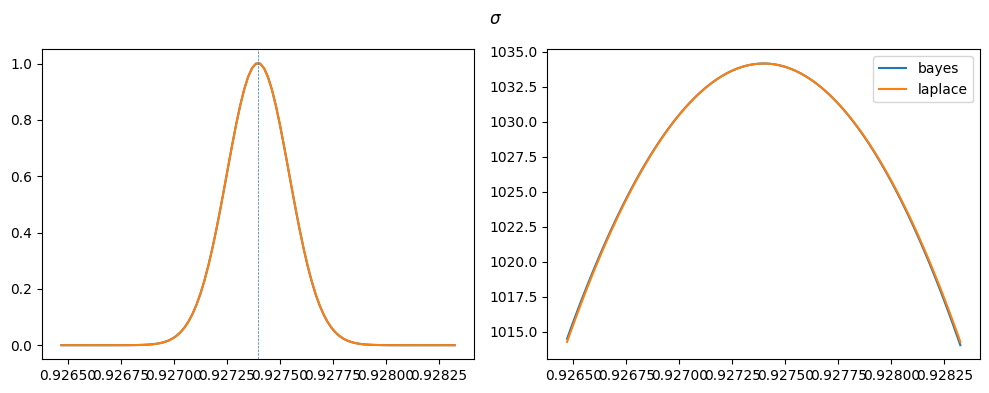

In [425]:
sigmas = np.linspace(sigma0*0.999, sigma0*1.001, 100)
prs_bayes = np.zeros_like(sigmas)
prs_laplace = np.zeros_like(sigmas)
logprmax = logPr_bayes(y, full, mean_X, covinv_X, theta_max)

for i, sigma_ in enumerate(sigmas):
    prs_bayes[i] = logPr_bayes(y, full, mean_X, covinv_X, [logLmax0, d0, sigma_])
    prs_laplace[i] = logPr_laplace(np.array([sigma_]), logprmax, sigma0, H[2][2])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(sigmas, np.exp(prs_bayes - prs_bayes.max()), label='bayes')
ax1.plot(sigmas, np.exp(prs_laplace - prs_laplace.max()), label='laplace')
ax1.axvline(x=sigma0, ls='--', lw=.5)
ax2.plot(sigmas, prs_bayes, label='bayes')
ax2.plot(sigmas, prs_laplace, label='laplace')
plt.suptitle('$\sigma$', y=0.97)
plt.legend();
plt.tight_layout()

### **Plotting errorbars**

In [5]:
nk = 500 * np.ones(2000)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
X = generate_Xs(nk)
theta_true = np.array([1, 10, 1])
y = full.func(X, theta_true)
theta_max = minimise_bayes(y, full, mean_X, covinv_X, theta_true).x
logLmax0, d0, sigma0 = theta_max
print(f'{theta_max}')
pr_thetamax = logPr_bayes(y, full, mean_X, covinv_X, theta_max)
print(f'pr(theta_true): {logPr_bayes(y, full, mean_X, covinv_X, theta_true)}')
print(f'pr(theta_b): {pr_thetamax}')

[0.9819923  9.52794421 1.01886881]
pr(theta_true): 481.4914606772478
pr(theta_b): 483.49774653035865


In [6]:
H = hess(y, mean_X, covinv_X, theta_max)
A = -H
cov_theta = np.linalg.inv(A)
H

array([[-2.52321290e+07,  7.58572687e+03, -2.36873418e+07],
       [ 7.58572687e+03, -1.23367633e+02,  2.32375849e+03],
       [-2.36873418e+07,  2.32375849e+03, -2.22875509e+07]])

In [7]:
np.linalg.eigvals(H)

array([-4.74928938e+07, -2.72393118e+04,  3.29841486e+02])

In [466]:
def Z(logpr_thetamax, H):
    pr_thetamax = np.exp(logpr_thetamax)
    det_Hinv = 1/np.linalg.det(H)
    return  pr_thetamax * np.sqrt(2*np.pi*det_Hinv)

Z(pr_thetamax, H)

1.1934230366084627e+173

/tmp/ipykernel_5647/1697681734.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  theta = np.random.multivariate_normal(theta_max, cov_theta)


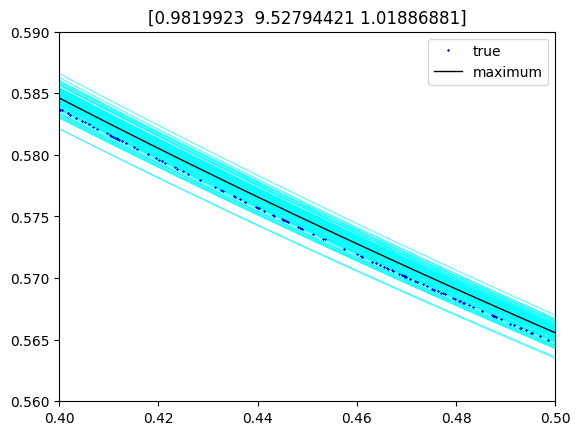

In [9]:
for i in range(100):
    theta = np.random.multivariate_normal(theta_max, cov_theta)
    X_b = full.inverse(y, theta)
    plt.plot(X_b, y, lw=.5, color='cyan')
plt.plot(X, y, 'x', ms=1, color='blue', label='true')
plt.plot(full.inverse(y, theta_max), y, lw=1, color='black', label='maximum')
plt.title(theta_max)
plt.xlim(0.4, 0.5)
plt.ylim(0.56, 0.59)
plt.legend();

/tmp/ipykernel_5647/3160451984.py:4: RuntimeWarning: covariance is not positive-semidefinite.
  theta = np.random.multivariate_normal(theta_max, cov_theta)


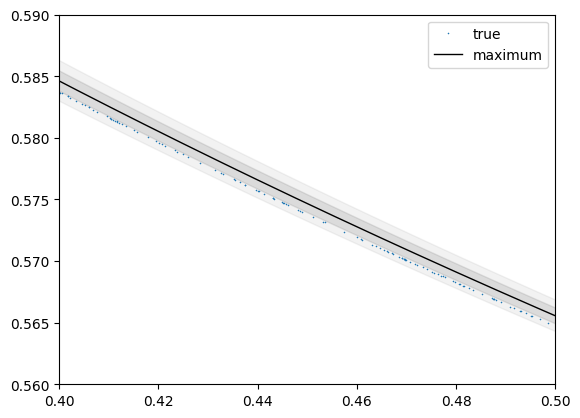

In [11]:
samples = 1000
Xarrays = np.zeros((samples, len(y)))
for i in range(samples):
    theta = np.random.multivariate_normal(theta_max, cov_theta)
    X_b = full.inverse(y, theta)
    Xarrays[i] = X_b
X_std = Xarrays.T.std(axis=1)
X_mean = Xarrays.T.mean(axis=1)

X_b = full.inverse(y, theta_max)
plt.plot(X, y, 'x', ms=.5, label='true')
plt.plot(X_b, y, lw=1, color='black', label='maximum')
# plt.plot(X_mean, y, lw=1, color='yellow', label='mean')
plt.fill_betweenx(y, X_b - 2*X_std, X_b + 2*X_std, color='gray', alpha=0.1)
plt.fill_betweenx(y, X_b - X_std, X_b + X_std, color='gray', alpha=0.2)
plt.xlim(0.4, 0.5)
plt.ylim(0.56, 0.59)
plt.legend();